In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc

In [7]:
train = pd.read_csv('train.csv')
campaign = pd.read_csv('campaign_data.csv')
items = pd.read_csv('item_data.csv')
coupons = pd.read_csv('coupon_item_mapping.csv')
cust_demo = pd.read_csv('customer_demographics.csv')
cust_tran = pd.read_csv('customer_transaction_data.csv')
test = pd.read_csv('test.csv')

In [8]:
train.shape, campaign.shape, items.shape, coupons.shape, cust_demo.shape, cust_tran.shape, test.shape

((78369, 5),
 (28, 4),
 (74066, 4),
 (92663, 2),
 (760, 7),
 (1324566, 7),
 (50226, 4))

In [9]:
print('Train Dataframe')
print(train.isnull().sum())
print('======================')
print('Campaign Dataframe')
print(campaign.isnull().sum())
print('======================')
print('Items Dataframe')
print(items.isnull().sum())
print('======================')
print('Coupons Dataframe')
print(coupons.isnull().sum())
print('======================')
print('Customer Demographics Dataframe')
print(cust_demo.isnull().sum())
print('======================')
print('Customer Transaction Dataframe')
print(cust_tran.isnull().sum())
print('======================')

print(test.isnull().sum())

Train Dataframe
id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64
Campaign Dataframe
campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
Items Dataframe
item_id       0
brand         0
brand_type    0
category      0
dtype: int64
Coupons Dataframe
coupon_id    0
item_id      0
dtype: int64
Customer Demographics Dataframe
customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64
Customer Transaction Dataframe
date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64
id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64


In [10]:
train.redemption_status.value_counts(normalize=True)*100

redemption_status
0    99.069785
1     0.930215
Name: proportion, dtype: float64

Text(0, 0.5, 'redemption_status')

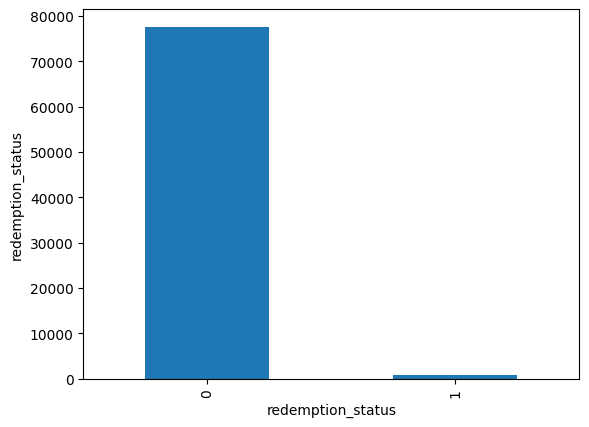

In [11]:
value=train['redemption_status'].value_counts().plot(kind='bar')
plt.ylabel('redemption_status')

In [12]:
cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [13]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [14]:
cust_demo.marital_status.value_counts()

marital_status
Married    317
Single     114
Name: count, dtype: int64

In [15]:
cust_demo['family_size'] = cust_demo.family_size.apply(lambda x: int(re.sub('\+','',x)))
cust_demo['no_of_children'] = cust_demo.no_of_children.apply(lambda x: int(re.sub('\+','',x)) if pd.notna(x) else x)

<>:1: SyntaxWarning: invalid escape sequence '\+'
<>:2: SyntaxWarning: invalid escape sequence '\+'
<>:1: SyntaxWarning: invalid escape sequence '\+'
<>:2: SyntaxWarning: invalid escape sequence '\+'
C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\439340053.py:1: SyntaxWarning: invalid escape sequence '\+'
  cust_demo['family_size'] = cust_demo.family_size.apply(lambda x: int(re.sub('\+','',x)))
C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\439340053.py:2: SyntaxWarning: invalid escape sequence '\+'
  cust_demo['no_of_children'] = cust_demo.no_of_children.apply(lambda x: int(re.sub('\+','',x)) if pd.notna(x) else x)


In [16]:
#Filling NaN values for marital_status

#customers with family size =1 will be single
cust_demo.loc[pd.isnull(cust_demo.marital_status) & (cust_demo.family_size == 1),'marital_status'] = 'Single'

#customers whos family size - no of childrens == 1, will also be single 
#This is applicable where there is only 1 parent --- We treat 1 parent as Single
cust_demo.loc[(cust_demo.family_size - cust_demo.no_of_children == 1) & pd.isnull(cust_demo.marital_status),'marital_status'] = 'Single'

#from the orignal data we have 186 of 196 customers with diff of 2 in their family size and number of childrens as
#Married (see the below cell) and hence where ever the difference is 2 and marital status is NaN and No of Children is 
#NaN we impute the Mariatl Status with Married
cust_demo.loc[(pd.isnull(cust_demo.marital_status)) & ((cust_demo.family_size - cust_demo.no_of_children) == 2)  
              & (pd.notnull(cust_demo.no_of_children)),'marital_status'] = 'Married'

#original data shows customers with fam size == 2, and NaN in no of childrens are majorly Married (see below cell skipping 1 cell)
cust_demo.loc[pd.isnull(cust_demo.marital_status) & (pd.isnull(cust_demo.no_of_children)) 
              & (cust_demo.family_size ==2),'marital_status'] = 'Married'

In [17]:
a = cust_demo.marital_status.groupby((cust_demo.family_size - cust_demo.no_of_children) == 2).value_counts()
print(a[True])

marital_status
Married    186
Single      10
Name: count, dtype: int64


In [18]:
cust_demo.marital_status.isnull().sum()

np.int64(0)

In [19]:
#FillingNaN values for no of children

#Married people with family_size ==2 will have 0 childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.marital_status == 'Married') & (cust_demo.family_size == 2),'no_of_children'] = 0

#customers with family size 1 will have zero childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 1), 'no_of_children'] = 0

#singles with family size == 2, will probably have 1 child
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 2),'no_of_children'] = 1

cust_demo['no_of_children']=cust_demo['no_of_children'].astype(np.int64)

In [20]:
cust_demo.no_of_children.isnull().sum()

np.int64(0)

In [21]:
#Label Encoding Marital Status --- 0 is Single and 1 is Married
encoder=LabelEncoder()
cust_demo["marital_status"] = encoder.fit_transform(cust_demo["marital_status"])

In [22]:
cust_demo["age_range"] = encoder.fit_transform(cust_demo["age_range"])

In [23]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [24]:
campaign.campaign_type.value_counts()

campaign_type
Y    22
X     6
Name: count, dtype: int64

In [25]:
#Label Encoding Campaign type
campaign["campaign_type"] = encoder.fit_transform(campaign.campaign_type)

In [26]:
#Converting the date columns to date time
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [27]:
#Creating a new column campaign_duration
campaign["campaign_duration"] = campaign["end_date"] - campaign["start_date"]
campaign["campaign_duration"] = campaign["campaign_duration"].apply(lambda x: x.days) 

In [28]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60
1,25,1,2013-10-21,2013-11-22,32
2,20,1,2013-09-07,2013-11-16,70
3,23,1,2013-10-08,2013-11-15,38
4,21,1,2013-09-16,2013-10-18,32


In [29]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [30]:
#Converting the date column into date time
#Reset the index of the DataFrame, and use the default one instead.
#If the DataFrame has a MultiIndex, this method can remove one or more levels.
cust_tran['date'] = pd.to_datetime(cust_tran['date'])
cust_tran = cust_tran.sort_values('date').reset_index(drop=True)

In [31]:
#Creating 3 new columns from the date column
cust_tran['day'] = cust_tran["date"].apply(lambda x: x.day)
cust_tran['dow'] = cust_tran["date"].apply(lambda x: x.weekday())
cust_tran['month'] = cust_tran["date"].apply(lambda x: x.month)

In [32]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,2,0,1
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62,2,0,1
2,2012-01-02,464,20717,2,28.50,-27.78,0.00,2,0,1
3,2012-01-02,464,21008,1,35.26,-17.81,0.00,2,0,1
4,2012-01-02,464,22243,2,118.97,-22.80,0.00,2,0,1


In [33]:
#Given selling_price and other_discount are for the entire transaction. Hence getting the Actual value of the transaction.
cust_tran.selling_price = cust_tran.selling_price/cust_tran.quantity
cust_tran.other_discount = cust_tran.other_discount/cust_tran.quantity
cust_tran.selling_price = cust_tran.selling_price - cust_tran.other_discount

In [34]:
#Inserting a new column to know if the coupon was used or not
cust_tran['coupon_used'] = cust_tran.coupon_discount.apply(lambda x: 1 if x !=0 else 0)

In [35]:
items.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [36]:
#Label Encoding the brand_type and category columns
items.brand_type = encoder.fit_transform(items["brand_type"])
items.category = encoder.fit_transform(items["category"])

In [37]:
items.head()

,item_id,brand,brand_type,category
0,1,1,0,6
1,2,1,0,8
2,3,56,1,1
3,4,56,1,6
4,5,56,1,6


In [38]:
coupons.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [39]:
coupons_items = pd.merge(coupons, items, on="item_id", how="left")

In [40]:
coupons_items.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,1,6
1,107,75,56,1,6
2,494,76,209,0,6
3,522,77,278,0,6
4,518,77,278,0,6


In [41]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,45.950,-10.69,0.00,2,0,1,0
1,2012-01-02,464,20697,1,113.630,-21.37,-35.62,2,0,1,1
2,2012-01-02,464,20717,2,28.140,-13.89,0.00,2,0,1,0
3,2012-01-02,464,21008,1,53.070,-17.81,0.00,2,0,1,0
4,2012-01-02,464,22243,2,70.885,-11.40,0.00,2,0,1,0


In [42]:
# Aggregate transactions by item_id by mean for a particular customer
transactions1 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used'],
               aggfunc={'customer_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum
                        } )
transactions1.reset_index(inplace=True)
transactions1.rename(columns={'customer_id': 'no_of_customers'}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\43181309.py:2: FutureWarning: The provided callable <function mean at 0x000001A23C2C8720> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  transactions1 = pd.pivot_table(cust_tran, index = "item_id",
C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\43181309.py:2: FutureWarning: The provided callable <function sum at 0x000001A23C2BB2E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transactions1 = pd.pivot_table(cust_tran, index = "item_id",


In [43]:
transactions1.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price
0,1,0.0,0,2,0.0,1.0,124.31
1,2,0.0,0,1,0.0,1.0,35.26
2,3,0.0,0,1,0.0,1.0,56.64
3,4,0.0,0,1,0.0,1.0,54.85
4,5,0.0,0,1,0.0,1.0,81.57


In [44]:
# Aggregate transactions by item_id by sum for a particular customer
transactions2 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'customer_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        } )
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 't_counts', 'quantity':'qu_sum',
                             'selling_price':'price_sum', 'other_discount':'od_sum',
                             'coupon_discount':'cd_sum'}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\1653061839.py:2: FutureWarning: The provided callable <function sum at 0x000001A23C2BB2E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transactions2 = pd.pivot_table(cust_tran, index = "item_id",


In [45]:
transactions1 = pd.merge(transactions1, transactions2, on='item_id',how='left' )

In [46]:
transactions1['total_discount_mean'] = transactions1['coupon_discount'] + transactions1['other_discount']
transactions1['total_discount_sum'] = transactions1['od_sum'] + transactions1['cd_sum']
transactions1.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,cd_sum,t_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


In [47]:
item_coupon_trans = pd.merge(coupons_items, transactions1, on='item_id', how='left')

In [48]:
item_coupon_trans.head()

,coupon_id,item_id,brand,brand_type,category,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,cd_sum,t_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,105,37,56,1,6,0.0,0.0,2.0,-8.108333,2.285714,57.247381,0.0,7.0,-56.758333,16.0,400.731667,-8.108333,-56.758333
1,107,75,56,1,6,0.0,0.0,4.0,-2.633712,1.363636,38.828485,0.0,33.0,-86.912500,45.0,1281.340000,-2.633712,-86.912500
2,494,76,209,0,6,0.0,0.0,1.0,-17.450000,1.000000,106.500000,0.0,1.0,-17.450000,1.0,106.500000,-17.450000,-17.450000
3,522,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-16.920000,-33.840000
4,518,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-16.920000,-33.840000


In [49]:
item_coupon_trans.columns

Index(['coupon_id', 'item_id', 'brand', 'brand_type', 'category',
       'coupon_discount', 'coupon_used', 'no_of_customers', 'other_discount',
       'quantity', 'selling_price', 'cd_sum', 't_counts', 'od_sum', 'qu_sum',
       'price_sum', 'total_discount_mean', 'total_discount_sum'],
      dtype='object')

In [50]:
coupon = pd.pivot_table(
    item_coupon_trans,
    index="coupon_id",
    values=[
        "item_id", "brand", "brand_type", "category",
        "coupon_discount", "coupon_used", "no_of_customers", "other_discount",
        "quantity", "selling_price", "cd_sum", "t_counts", "od_sum", "qu_sum",
        "price_sum", "total_discount_mean", "total_discount_sum"
    ],
    aggfunc={
        "item_id": lambda x: len(set(x)),
        "brand": lambda x: x.mode()[0],  # Using pandas.Series.mode
        "brand_type": lambda x: x.mode()[0],
        "category": lambda x: x.mode()[0],
        "coupon_discount": np.mean,
        "no_of_customers": np.mean,
        "other_discount": np.mean,
        "quantity": np.mean,
        "selling_price": np.mean,
        "coupon_used": np.sum,
        "cd_sum": np.sum,
        "t_counts": np.sum,
        "od_sum": np.sum,
        "qu_sum": np.sum,
        "price_sum": np.sum,
        "total_discount_mean": np.mean,
        "total_discount_sum": np.sum
    }
)
coupon.reset_index(inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\798626218.py:1: FutureWarning: The provided callable <function mean at 0x000001A23C2C8720> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  coupon = pd.pivot_table(
C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\798626218.py:1: FutureWarning: The provided callable <function sum at 0x000001A23C2BB2E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  coupon = pd.pivot_table(


In [51]:
coupon.rename(columns={'item_id':'item_counts'}, inplace=True)

In [52]:
coupon.head()

,coupon_id,brand,brand_type,category,cd_sum,coupon_discount,coupon_used,item_counts,no_of_customers,od_sum,other_discount,price_sum,qu_sum,quantity,selling_price,t_counts,total_discount_mean,total_discount_sum
0,1,1475,0,9,-1526.31,-1.321524,35.0,39,14.794872,-18780.020833,-16.620713,89796.868333,1034.0,1.221644,101.183245,826.0,-17.942237,-20306.330833
1,2,2084,0,6,0.00,0.000000,0.0,2,15.000000,-1163.521667,-21.343885,8940.520000,103.0,1.137500,122.534500,81.0,-21.343885,-1163.521667
2,3,278,0,6,-578.81,-2.747358,15.0,17,8.588235,-4055.343333,-14.728021,27756.490000,248.0,1.121525,131.655894,212.0,-17.475379,-4634.153333
3,4,544,0,6,-881.59,-1.485152,44.0,24,22.333333,-25895.740000,-36.718597,142874.023333,702.0,1.020872,211.708369,676.0,-38.203749,-26777.330000
4,5,5357,0,11,0.00,0.000000,0.0,7,6.000000,-1228.880000,-27.265786,16636.570000,44.0,1.000000,403.970000,44.0,-27.265786,-1228.880000


In [53]:
from scipy.stats import mode

transactions3 = pd.pivot_table(
    cust_tran,
    index="customer_id",
    values=['item_id', 'quantity', 'selling_price', 'other_discount', 'coupon_discount', 'coupon_used', 'day', 'dow', 'month'],
    aggfunc={
        'item_id': lambda x: len(set(x)),
        'quantity': np.mean,
        'selling_price': np.mean,
        'other_discount': np.mean,
        'coupon_discount': np.mean,
        'coupon_used': np.sum,
        'day': lambda x: mode(x, keepdims=True).mode[0] if len(x) > 0 else np.nan,
        'dow': lambda x: mode(x, keepdims=True).mode[0] if len(x) > 0 else np.nan,
        'month': lambda x: mode(x, keepdims=True).mode[0] if len(x) > 0 else np.nan
    }
)
transactions3.reset_index(inplace=True)
transactions3.rename(columns={'item_id': 'no_of_items'}, inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\3221818682.py:3: FutureWarning: The provided callable <function mean at 0x000001A23C2C8720> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  transactions3 = pd.pivot_table(
C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\3221818682.py:3: FutureWarning: The provided callable <function sum at 0x000001A23C2BB2E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transactions3 = pd.pivot_table(


In [54]:
# Aggregate transactions by customer_id by sum
transactions4 = pd.pivot_table(cust_tran, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'item_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum}
              )
transactions4.reset_index(inplace=True)
transactions4.rename(columns={'item_id': 'customer_id_count','quantity':'qa_sum','selling_price':'pprice_sum',
                             'other_discount':'odd_sum','coupon_discount':'cdd_sum'  }, inplace=True)
transactions4.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\706797692.py:2: FutureWarning: The provided callable <function sum at 0x000001A23C2BB2E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transactions4 = pd.pivot_table(cust_tran, index = "customer_id",


,customer_id,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-249.34,419,-5628.089833,474,45170.623167
2,3,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-89.05,220,-1954.404333,280,30416.489333
4,5,-90.83,792,-8918.471477,93353,91462.410620


In [55]:
transactions = pd.merge(transactions3, transactions4, on='customer_id', how='left')
transactions.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,97.470480,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842,-90.83,792,-8918.471477,93353,91462.410620


In [56]:
def merge_all(df): 
    df=  pd.merge(df, coupon, on="coupon_id", how="left")
    df = pd.merge(df, campaign, on="campaign_id", how="left")
    df = pd.merge(df, cust_demo, on="customer_id", how="left")
    df = pd.merge(df, transactions, on='customer_id', how='left')
    return df

In [57]:
train = merge_all(train)
test = merge_all(test)

In [58]:
train.shape, test.shape

((78369, 46), (50226, 45))

In [59]:
train.isnull().sum()
#data is ready

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
redemption_status          0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              34708
marital_status         34708
rented                 34708
family_size            34708
no_of_children         34708
income_bracket         34708
coupon_discount_y          0
coupon_used_y              0
day           

In [60]:
test.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              19287
marital_status         19287
rented                 19287
family_size            19287
no_of_children         19287
income_bracket         19287
coupon_discount_y          0
coupon_used_y              0
day                        0
dow           

In [61]:
from scipy.stats import mode

def deal_na(df):
    for col in df.columns.tolist()[1:]:
        if df[col].isnull().any():  # Check if there are missing values
            most_common_value = mode(df[col].dropna(), keepdims=True).mode[0]
            df[col].fillna(most_common_value, inplace=True)
    return df

train = deal_na(train)
test = deal_na(test)


C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\632969191.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(most_common_value, inplace=True)


In [62]:
train.isnull().sum()

id                     0
campaign_id            0
coupon_id              0
customer_id            0
redemption_status      0
brand                  0
brand_type             0
category               0
cd_sum                 0
coupon_discount_x      0
coupon_used_x          0
item_counts            0
no_of_customers        0
od_sum                 0
other_discount_x       0
price_sum              0
qu_sum                 0
quantity_x             0
selling_price_x        0
t_counts               0
total_discount_mean    0
total_discount_sum     0
campaign_type          0
start_date             0
end_date               0
campaign_duration      0
age_range              0
marital_status         0
rented                 0
family_size            0
no_of_children         0
income_bracket         0
coupon_discount_y      0
coupon_used_y          0
day                    0
dow                    0
no_of_items            0
month                  0
other_discount_y       0
quantity_y             0


In [63]:
test.isnull().sum()

id                     0
campaign_id            0
coupon_id              0
customer_id            0
brand                  0
brand_type             0
category               0
cd_sum                 0
coupon_discount_x      0
coupon_used_x          0
item_counts            0
no_of_customers        0
od_sum                 0
other_discount_x       0
price_sum              0
qu_sum                 0
quantity_x             0
selling_price_x        0
t_counts               0
total_discount_mean    0
total_discount_sum     0
campaign_type          0
start_date             0
end_date               0
campaign_duration      0
age_range              0
marital_status         0
rented                 0
family_size            0
no_of_children         0
income_bracket         0
coupon_discount_y      0
coupon_used_y          0
day                    0
dow                    0
no_of_items            0
month                  0
other_discount_y       0
quantity_y             0
selling_price_y        0


In [64]:
test_id = test['id']
target = train['redemption_status']
train.drop(['id','campaign_id','start_date','end_date', 'redemption_status'], axis=1, inplace=True)
test.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [65]:
train.head()

,coupon_id,customer_id,brand,brand_type,category,cd_sum,coupon_discount_x,coupon_used_x,item_counts,no_of_customers,...,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,27,1053,1105,0,6,-5349.93,-1.241694,191.0,125,19.224000,...,208,5,-25.583099,340.487097,163.966826,-89.05,310,-7930.760842,105551,50829.715972
1,116,48,56,1,6,0.00,0.000000,0.0,3,20.333333,...,244,6,-20.013685,31.540260,188.638474,-1237.79,385,-7705.268702,12143,72625.812434
2,635,205,560,0,11,-605.54,-2.987321,15.0,67,1.761194,...,533,3,-12.873370,1.392784,112.067666,-2145.72,970,-12487.169143,1351,108705.636349
3,644,1050,611,0,6,-17.81,-4.452500,1.0,4,3.500000,...,216,8,-12.880868,1.291139,100.896997,-178.10,237,-3052.765833,306,23912.588333
4,1017,1489,1558,0,6,-569.92,-0.198055,23.0,32,27.312500,...,327,5,-12.264174,247.443060,85.016352,-265.01,562,-6892.466021,139063,47779.189609


In [66]:
target

0        0
1        0
2        0
3        0
4        0
        ..
78364    0
78365    0
78366    0
78367    0
78368    0
Name: redemption_status, Length: 78369, dtype: int64

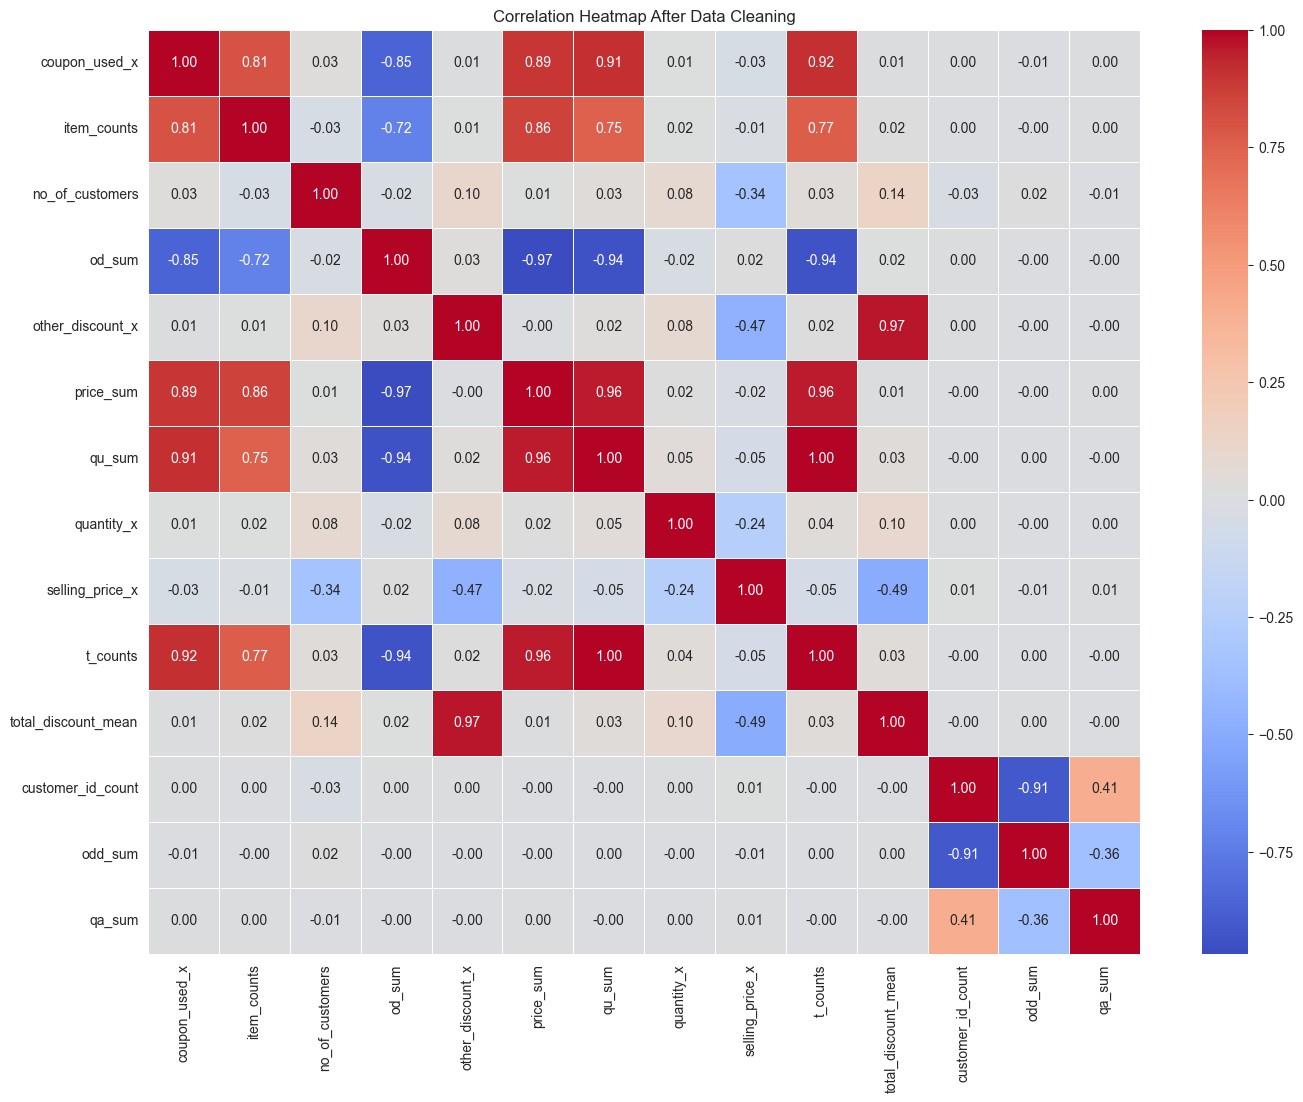

In [104]:
# Selecting specific columns from the cleaned DataFrame
selected_columns = train.iloc[:, list(range(7, 18)) + list(range(37, 40))]

# Plot the heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = selected_columns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap After Data Cleaning")
plt.show()



In [67]:
x = pd.DataFrame(train)
y = target
col_names = ['cd_sum','coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'campaign_duration',
        'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y',
       'no_of_items', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum',
       'pprice_sum']
features = x[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
x[col_names] = features
x = np.array(x)

In [68]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2439)

In [69]:
LR = LogisticRegression(max_iter=200)
LR.fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)
print(classification_report(y_test,y_pred_LR))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.11      0.00      0.01       207

    accuracy                           0.99     23511
   macro avg       0.55      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
roc_auc_score(y_test,y_pred_LR)
Model = ['Logistic Regression']
ROC_AUC_Accuracy = [roc_auc_score(y_test,y_pred_LR)]

In [71]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results=confusion_matrix(y_test,y_pred_LR)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_LR) )
print ('Report : ')
print (classification_report(y_test,y_pred_LR) )

Confusion Matrix :
[[23296     8]
 [  206     1]]
Accuracy Score : 0.9908978775892135
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.11      0.00      0.01       207

    accuracy                           0.99     23511
   macro avg       0.55      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



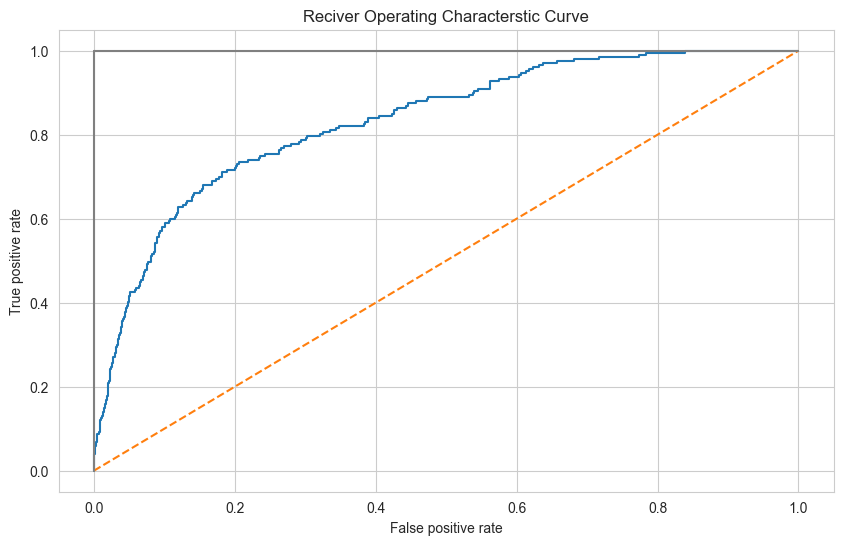

In [72]:
#Plot ROC Curve
#Get predicted probabilites
target_probailities_log = LR.predict_proba(x_test)[:,1]
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [75]:
params = {
    
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}
from sklearn.model_selection import RandomizedSearchCV
dt = DecisionTreeClassifier()

rs = RandomizedSearchCV(estimator=dt,n_jobs=-1,cv=3,param_distributions=params,scoring='recall')
rs.fit(x,y)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py",

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': range(2, 10),
                                        'splitter': ['best', 'random']},
                   scoring='recall')

In [76]:
dt = DecisionTreeClassifier(**rs.best_params_)
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print(roc_auc_score(y_test,y_pred_dt))
Model.append('Decision Tree')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_dt))

0.5


In [77]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.00      0.00      0.00       207

    accuracy                           0.99     23511
   macro avg       0.50      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [78]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Decision Tree'],
 [np.float64(0.5022438145842973), np.float64(0.5)])

In [79]:
results=confusion_matrix(y_test,y_pred_dt)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_dt) )
print ('Report : ')
print (classification_report(y_test,y_pred_dt) )

Confusion Matrix :
[[23304     0]
 [  207     0]]
Accuracy Score : 0.9911956105652673
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.00      0.00      0.00       207

    accuracy                           0.99     23511
   macro avg       0.50      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [80]:
#Function to visulise confusion matrix
def draw_cm( y_test,y_pred_dt):
    cm = metrics.confusion_matrix( y_test,y_pred_dt )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] , cmap="Greens")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [81]:
from sklearn.metrics import classification_report,confusion_matrix
mat_pruned = confusion_matrix(y_test,y_pred_dt )

print("confusion matrix = \n",mat_pruned)


confusion matrix = 
 [[23304     0]
 [  207     0]]


In [82]:
def create_conf_mat(y_test,y_pred_dt):
    if (len(y_test.shape) != len(y_pred_dt.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != y_pred_dt.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = y_test,
                                       columns = y_pred_dt)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

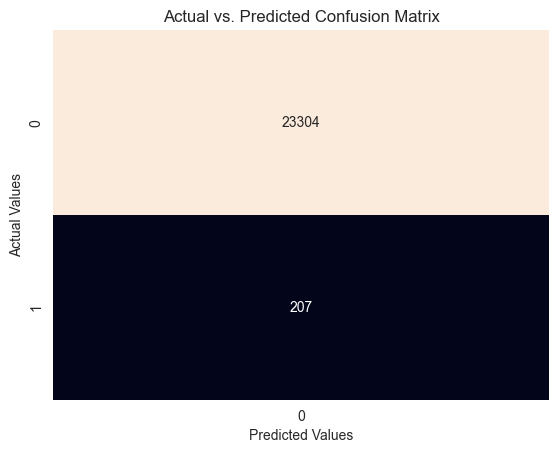

In [83]:
conf_mat = create_conf_mat(y_test,y_pred_dt)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(x_train, y_train)

# Make predictions
y_pred = rf.predict(x_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.9912
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.48      0.07      0.13       207

    accuracy                           0.99     23511
   macro avg       0.74      0.54      0.56     23511
weighted avg       0.99      0.99      0.99     23511



In [85]:
# Predict on test data
test_predictions = rf.predict(test)

# Create a DataFrame for the test predictions
test_result = pd.DataFrame({'id': test_id, 'redemption_status': test_predictions})

# Check the first few results
print(test_result.head())


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


   id  redemption_status
0   3                  1
1   4                  0
2   5                  1
3   8                  0
4  10                  0


C:\Users\Admin\AppData\Local\Temp\ipykernel_6264\1664270594.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_indices], y=feature_names[sorted_indices], palette="viridis")


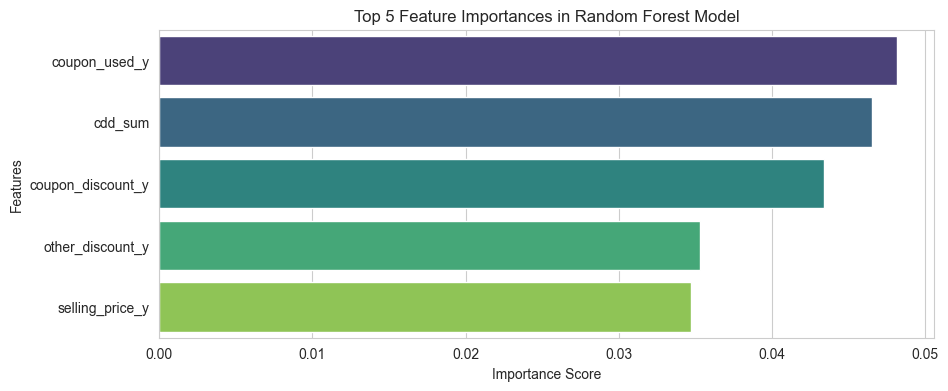

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming 'rf' is the trained Random Forest model and 'train' is the feature set
importances = rf.feature_importances_
feature_names = pd.DataFrame(train).columns

# Sort and get top 5 features
sorted_indices = np.argsort(importances)[::-1][:5]

# Plot top 5 feature importances
plt.figure(figsize=(10, 4))
sns.barplot(x=importances[sorted_indices], y=feature_names[sorted_indices], palette="viridis")
plt.title("Top 5 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
